In [1]:
# load important modules
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
data = pd.DataFrame(pd.read_excel('data/sarcopenia.xlsx'))

# drop duplicated rows
data.drop(data[data.drop("Folio", axis=1).duplicated()].index, inplace=True)

# Genero 1: male, 2: female => change to 0: male, 1: female
# SI: 1, NO: 2 => change to NO: 0, YES: 1
data['Genero'] = data['Genero'].replace({1: 0, 2: 1})

# overview of data
print("shape:", data.shape)
print("\"Misses\" in:")
print(data.loc[:,data.isna().any()].info())
print("Indexes of rows with misses:", data[data.isna().any(axis=1)].index)

#print(data['Marcha'].value_counts(dropna=False).sort_index())
#print(data['Hb'].value_counts(dropna=False).sort_index())
#print("Columns:\n",data.columns)
#data.describe()

# HB: meaning of 0? Guess 0 = NaN
data['Hb'].fillna(0, inplace=True)
# treating nans8
# Marcha: meaning of 0? If 0 = NaN: 8 NaN can be imputed with mean
data['Marcha'].fillna(data['Marcha'].mean(), inplace=True)
data['Marcha'] = data['Marcha'].replace({0:data['Marcha'].mean()})


# Change encoding, so that 0 always equals ninguno/-a or regular, depending on the scale
data['Cuidador'].replace({6 : 0}, inplace=True)
data['Letrado'].replace({3 : 0}, inplace=True)
data['Religiòn'].replace({5 : 0}, inplace=True)
data['Economìa'].replace({2 : 0, 3 : -1}, inplace=True)
data['Ocupacion'].replace({1: 0, 2:1, 3:2, 4:3}, inplace=True)
data['Manutencion'].replace({5 : 0}, inplace=True)
data['Visiòn'].replace({1:2, 2:1, 3:0, 4:-1, 5:-2}, inplace=True)
data['Audiciòn'].replace({1:2, 2:1, 3:0, 4:-1, 5:-2}, inplace=True)
data['CorreccionVisual'].replace({1:3, 3:1, 4:-1, 5:-2}, inplace=True)
data['CorreccionAuditiva'].replace({1:3, 3:1, 4:-1, 5:-2}, inplace=True)
data['Tabaquismo'].replace({1:0, 2:1, 3:-1}, inplace=True)
data['Alcoholismo'].replace({1:0, 2:1, 3:-1}, inplace=True)
data['Drogas'].replace({1:0, 2:1, 3:-1}, inplace=True)

shape: (233, 84)
"Misses" in:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Marcha  231 non-null    float64
 1   Hb      232 non-null    float64
dtypes: float64(2)
memory usage: 5.5 KB
None
Indexes of rows with misses: Int64Index([24, 191, 210], dtype='int64')


In [3]:
# usefull functions and declaration of variables which will be used later
drop_col = []

# drop features stored as strings in feats from dataframe df
def drop_feat(df, feats):
    for feature in feats:
        if feature in df.columns: df.drop(feature, axis=1, inplace=True)
    return df

# get name of all binary features from dataframe df
# returns array with names
def get_binary_features(df):
    return [feature for feature in df.columns 
     if len(data[feature].value_counts()) <= 2]

In [4]:
#### Remarks about encoding and features ####
# Charlson (2-10) : Not in excel, no understanding of meaning
# MM & IMM Meaning?
# FuerzaPrension => not binary, in excel as binary (https://pubmed.ncbi.nlm.nih.gov/21624928/)
# GDS (0-5): Meaning/Encoding unclear, not in excel

#### NANs for every feature ####
# MMSE : 0 = none? : 7 cases (exel says below 14 DETERIORO GRAVE)
# GDS : not in exel, none = 0 in 60 cases?
# Barthel : encoding of excel does not match encoding in data
# Norton : encoding of excel does not match encoding in data
# Lawton : encoding of excel does not match encoding in data
# MNA : encoding of excel does not match encoding in data
# Hb: none = 0 : 130 cases
# urea: none = 0 : 144 cases
# Creatina: none = 0 : 128 cases
# Albumina: none = 0 : 188 cases
# Glucosa: none = 0 : 121 cases
# Sodio: none = 0 : 154 cases

# Charlson, IMM, MM, GDS, FuerzaPrension

In [5]:
# drop (marked yellow in dataset), results in binary attributs
drop_col.extend(['MMSEx', 'MMSE', 'Barthel', 'BarthelX', 'NortonX', 'Norton',
                 'Lawton', 'LawtonX', 'MNAx', 'MNA', 'MM'])

# Folio = ID = index+1: no information
if "Folio" not in drop_col: drop_col.append("Folio")

data = drop_feat(data, drop_col)

# get all binary features
binary_features = get_binary_features(data)
data[binary_features[1:]] = data[binary_features[1:]].replace({2:0})

# apply variance threshold for binary
sel_bin = VarianceThreshold(threshold=(0.90*(1-0.90)))
sel_bin.fit_transform(data[binary_features])
mask = sel_bin.get_support()

for i in range(len(binary_features)):
        if not mask[i] and binary_features[i] not in drop_col: drop_col.append(binary_features[i])

print("Binary features with too low variance:\n", drop_col)

# get features which are not binary and have at least 95% of the same value
for i in data.columns:
    if (i not in binary_features) and (i not in drop_col) and (data[i].value_counts(dropna=False).tolist()[0] > 0.9*data.shape[0]):
        drop_col.append(i)

print("To drop because of low variance or entropy:\n", drop_col)
# categorical features: 
# Escolaridad (0-16), Letrado (1-3), EdoCivil (1-5), Cuidador (1-6), 
# Religion (1-5), Residencia (1-5), Ocupacion(1-4), Economia (1-3),
# Manutencion (1-5), Vision (1-3/1-5), CorreccionVisual (0-5), 
# Audicion (1-3/1-4), CorreccionAuditiva (0-4), MED1, MED2, MED3, MED4,
# MED5, MED6, MED7, MED8, MED9, MED10, Tabaquismo (1-3), Alcoholismo (1-3)
# Drogas (1-3)

# continous feature, which are encoded as categoricals/binary: => delete 2 versions?
# MMSE/MMSEx/MMSEcodif, Barthel/BarthelX/BarthelAR, Norton/NortonX/NortonAlto, Lawton/LawtonX, MNA/MNAx


# LawtonAR: check relation to LawtonX, maybe some errors?
#print(pd.crosstab(data['LawtonX'], data['LawtonAR'], margins='all'))
# MNAAR: check realtion to MNAx, maybe some errors?
#print(pd.crosstab(data['MNAx'], data['MNAAR'], margins='all'))
#print(str(data[(data['LawtonAR']==0) & (data['LawtonX'] == 3)].index)
#      +"\n"+
#      str(data[(data['LawtonAR']==1) & (data['LawtonX']==5)].index)
#      +"\n"+
#     str(data[(data['MNAAR']==0) & (data['MNAx'] == 3)].index))

Binary features with too low variance:
 ['MMSEx', 'MMSE', 'Barthel', 'BarthelX', 'NortonX', 'Norton', 'Lawton', 'LawtonX', 'MNAx', 'MNA', 'MM', 'Folio', 'OSTEOP', 'GASTRITIS', 'HIPOTIROIDISMO', 'HIPERTENSION', 'CANCER', 'InsfHepatica', 'Ùlceras', 'Infecciòn']
To drop because of low variance or entropy:
 ['MMSEx', 'MMSE', 'Barthel', 'BarthelX', 'NortonX', 'Norton', 'Lawton', 'LawtonX', 'MNAx', 'MNA', 'MM', 'Folio', 'OSTEOP', 'GASTRITIS', 'HIPOTIROIDISMO', 'HIPERTENSION', 'CANCER', 'InsfHepatica', 'Ùlceras', 'Infecciòn', 'Residencia', 'CorreccionAuditiva', 'MED9', 'MED10']


In [6]:
data = drop_feat(data, drop_col)

# get correlation matrix
corr_spear = data.corr('spearman')
corr_pearson = data.corr('pearson')
corr_kendall = data.corr('kendall')

# get features with strong relation in medicine/psychology
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6107969/
high_pearson = [] # 0.7 to 1.0
high_spear = []
high_kendall = []
for i in range(data.shape[1]):
    for j in range(i):
        pearson_corr = np.abs(corr_pearson.iloc[i,j])
        spearman_corr = np.abs(corr_spear.iloc[i,j])
        kendall_corr = np.abs(corr_kendall.iloc[i,j])
        if 0.7 <= pearson_corr:
            high_pearson.append((corr_pearson.columns[i], corr_pearson.columns[j], corr_pearson.iloc[i][j]))
        if 0.7 <= spearman_corr:
            high_spear.append((corr_spear.columns[i], corr_spear.columns[j], corr_spear.iloc[i][j]))
        if 0.7 <= kendall_corr:
            high_kendall.append((corr_kendall.columns[i], corr_kendall.columns[j], corr_kendall.iloc[i][j]))


#high_corr = []
#for p in high_pearson:
#    if p in high_kendall and p in high_spear:
#        high_corr.append(p)

#print("spearman correlation")
#print(pd.DataFrame(high_spear))
#print('kendall correlation')
#print(pd.DataFrame(high_kendall))
#print('pearson correlation')
#print(pd.DataFrame(high_pearson))
#corr.dropna(how='all').T.dropna(how='all').style.background_gradient('RdBu', vmax=1, vmin=-1)

# try building model from 3 features by definition

print("High Pearson Correlation: ", high_pearson)
print("High Spearman Correlation: ", high_spear)
print("High Kendall Correlation: ", high_kendall)

High Pearson Correlation:  [('OA', 'Visiòn', -0.7196685712522948), ('NùmeroDeCaìdas', 'Caìdas', 0.7030366149456374), ('Creatinina', 'Urea', 0.7994116738931769), ('Glucosa', 'Hb', 0.7812125936635224), ('Glucosa', 'Urea', 0.721906997873541), ('Glucosa', 'Creatinina', 0.7934611572233724), ('Sodio', 'Urea', 0.7343328170353899)]
High Spearman Correlation:  [('OA', 'Visiòn', -0.767579938948238), ('MED8', 'MED7', 0.7610229016320863), ('Drogas', 'Visiòn', -0.7012526441807251), ('NùmeroDeCaìdas', 'Caìdas', 0.9457066390799906), ('Creatinina', 'Urea', 0.792018911952844), ('Glucosa', 'Hb', 0.7404099543937226), ('Glucosa', 'Urea', 0.7283005989336238), ('Glucosa', 'Creatinina', 0.7889877926030032), ('Sodio', 'Urea', 0.7778092439720753)]
High Kendall Correlation:  [('OA', 'Visiòn', -0.7000899413156257), ('NùmeroDeCaìdas', 'Caìdas', 0.8766335417280183)]


In [7]:
# add features with high correlation to drop_col
#for pair in high_pearson:
#    if pair[0] == 'IMM' and pair[1] not in drop_col:
#        drop_col.append(pair[1])
#        continue
#    if pair[0] in drop_col or pair[1] in drop_col:
#        continue
#    if pair[0] not in drop_col: drop_col.append(pair[0])
#for pair in high_kendall:
#    if pair[0] == 'IMM' and pair[1] not in drop_col:
#        drop_col.append(pair[1])
#        continue
#    if pair[0] in drop_col or pair[1] in drop_col:
#        continue
#    if pair[0] not in drop_col: drop_col.append(pair[0])
#for pair in high_spear:
#    if pair[0] == 'IMM' and pair[1] not in drop_col:
#        drop_col.append(pair[1])
#        continue
#    if pair[0] in drop_col or pair[1] in drop_col:
#        continue
#    if pair[0] not in drop_col: drop_col.append(pair[0])

# drop unnecessary features

# idealise dataset by dropping every column which contains misses:
drop_col.extend(['Hb', 'Urea', 'Creatinina', 'Albumina', 'Glucosa', 'Sodio'])
drop_col.extend(['Caìdas']) # included in Numero de Caidas
idel_data = drop_feat(data, drop_col)
# drop duplicates in idealised dataset
idel_data.drop(idel_data[idel_data.duplicated()].index, inplace=True)
#idel_data.drop(data.duplicated())
print(idel_data.shape)

(231, 53)


In [8]:
#for i in idel_data.columns:
#    print(idel_data[i].value_counts())

In [26]:
# every feature ranges between 0 and 1
minmax = MinMaxScaler()
data_norm = pd.DataFrame(minmax.fit_transform(idel_data), columns=idel_data.columns)


# moderate = decrease of IMM and (grip power or walking speed)
# serve = decrease of IMM and grip power and walking speed

# 18 from serve_sarco differ to definition and 7 from definition differ to serve_sarco
# 24/41 samples can be classified as serve by IMM, FuerzaPrension and Marcha
serve_sarco = data_norm.loc[data_norm['Sarcopenia']==1] # 42 samples
mild_sarco = data_norm.loc[data_norm['Sarcopenia']==0] # 189 samples

# serve sarcopenia cases by definition given in excelsheet
serve_def = data_norm[((data_norm['Genero']==1) &
           (data_norm['Marcha']<=0.423) &
           (data_norm['IMM'] <= 0.075)) |
         ((data_norm['Genero']==0) &
           (data_norm['Marcha'] <= 0.423) &
           (data_norm['IMM'] <= 0.23))] # 31 samples

# get differences
#diff = serve_sarco.merge(serve_def, how='left', indicator=True)
#diff[diff['_merge'] != 'both'].shape[0]

idel_data.loc[idel_data['Sarcopenia']==1].describe()
#idel_data.loc[idel_data['Sarcopenia']==0].describe()

,Genero,Edad,Escolaridad,Letrado,EdoCivil,Cuidador,Religiòn,Ocupacion,Economìa,Manutencion,...,IMM,AnguloF,FuerzaPrension,Pantorrilla,Marcha,Sarcopenia,Demencia,Congiciòn,EVC,Dolor
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.0,42.000000,42.000000,42.000000,42.000000
mean,0.690476,81.452381,4.666667,1.142857,2.785714,2.452381,1.095238,0.833333,-0.142857,2.095238,...,6.692857,4.661905,0.261905,30.692857,0.713600,1.0,0.404762,0.690476,0.190476,0.238095
std,0.467901,7.322542,4.159425,0.521322,1.279019,1.810570,0.297102,0.762431,0.354169,1.649974,...,1.786212,1.256001,0.445001,3.323119,0.335751,0.0,0.496796,0.467901,0.397437,0.431081
min,0.000000,69.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,...,4.950000,3.500000,0.000000,25.500000,0.053000,1.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,76.750000,0.250000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,5.310000,3.900000,0.000000,28.250000,0.510000,1.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,81.000000,3.500000,1.000000,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,...,5.910000,4.200000,0.000000,30.000000,0.670000,1.0,0.000000,1.000000,0.000000,0.000000
75%,1.000000,85.750000,6.750000,1.000000,3.000000,4.000000,1.000000,1.000000,0.000000,4.000000,...,8.177500,5.250000,0.750000,33.000000,0.965000,1.0,1.000000,1.000000,0.000000,0.000000
max,1.000000,95.000000,12.000000,2.000000,5.000000,5.000000,2.000000,3.000000,0.000000,4.000000,...,12.130000,8.500000,1.000000,39.000000,1.560000,1.0,1.000000,1.000000,1.000000,1.000000


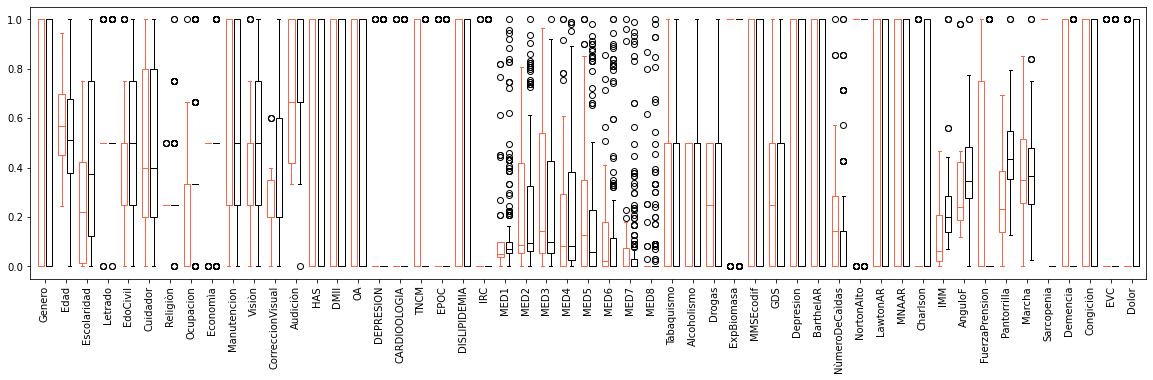

In [10]:
def draw_plot(data, offset, edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

# boxplot of serve and mild sarcopenia cases
fig, ax = plt.subplots(figsize=(20,5))
draw_plot(serve_sarco, -0.2, "tomato", "white")
draw_plot(mild_sarco, +0.2, "black", "white")
plt.xticks([i for i in range(data_norm.shape[1])], data_norm.columns, rotation=90)
plt.savefig("boxplot_serve_mild.png")
plt.show()



In [11]:
X = data_norm.drop("Sarcopenia", axis=1)
y = data_norm['Sarcopenia']

In [17]:
# get 5 best features with chi2, f1 score
print("Best 5 features with:")
X_chi2_5 = SelectKBest(chi2, k=5).fit(X, y)
chi2_5_names = X_chi2_5.get_feature_names_out(X.columns)
print("chi2:", chi2_5_names)
X_f1_5 = SelectKBest(f_classif, k=5).fit(X,y)
f1_5_names = X_f1_5.get_feature_names_out(X.columns)
print("F1:", f1_5_names)
intersec_5 = [i for i in chi2_5_names if i in f1_5_names]
print("Intersection: ", intersec_5)


# get 10 best features with chi2, f1 score
print("Best 10 features with:")
X_chi2_10 = SelectKBest(chi2, k=10).fit(X, y)
chi2_10_names = X_chi2_10.get_feature_names_out(X.columns)
print("chi2:", chi2_10_names)
X_f1_10 = SelectKBest(f_classif, k=10).fit(X,y)
f1_10_names = X_f1_10.get_feature_names_out(X.columns)
print("F1:", f1_10_names)
intersec_10 = [i for i in chi2_10_names if i in f1_10_names]
print("Intersection: ", intersec_10)


# get 20 best features with chi2, f1 score
#print("Best 20 features with:")
#X_chi2_20 = SelectKBest(chi2, k=20).fit(X, y)
#print("chi2:", X_chi2_20.get_feature_names_out(X.columns))
#X_f1_20 = SelectKBest(f_classif, k=20).fit(X,y)
#print("F1:", X_f1_20.get_feature_names_out(X.columns))

Best 5 features with:
chi2: ['TNCM' 'IMM' 'FuerzaPrension' 'Pantorrilla' 'Demencia']
F1: ['CorreccionVisual' 'TNCM' 'IMM' 'Pantorrilla' 'Demencia']
Intersection:  ['TNCM', 'IMM', 'Pantorrilla', 'Demencia']
Best 10 features with:
chi2: ['CorreccionVisual' 'TNCM' 'LawtonAR' 'Charlson' 'IMM' 'FuerzaPrension'
 'Pantorrilla' 'Demencia' 'Congiciòn' 'Dolor']
F1: ['Edad' 'Ocupacion' 'CorreccionVisual' 'TNCM' 'NortonAlto' 'IMM'
 'FuerzaPrension' 'Pantorrilla' 'Demencia' 'Congiciòn']
Intersection:  ['CorreccionVisual', 'TNCM', 'IMM', 'FuerzaPrension', 'Pantorrilla', 'Demencia', 'Congiciòn']
